This is my first (last?) blog post. I started writing this post as an assignement for Udacity's Data Scientist nanodegree. 

In the end, this exercise was quite interesting and I learned a few tricks on the way. I am aspiring data scientist and I don't have the exultant self-confidence that you can find in even the worst blog posts available online. To make things more interesting, I decided to write as much about the business questions selected for this data as I discuss the very process of inquiring data and all the doubts and questions that arise from it.

In [1129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re as re

%matplotlib inline

In [1185]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.feature_extraction import text 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [487]:
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)

Each city has three datasets: calendar, listings and reviews. Let's load all of them.

In [697]:
boston_calendar = pd.read_csv('data/boston/calendar.csv')
boston_listings = pd.read_csv('data/boston/listings.csv')
boston_reviews = pd.read_csv('data/boston/reviews.csv')

seattle_calendar = pd.read_csv('data/seattle/calendar.csv')
seattle_listings = pd.read_csv('data/seattle/listings.csv')
seattle_reviews = pd.read_csv('data/seattle/reviews.csv')

The calendar dataframe looks very ordinary. It tells us the id of the property and if it is available or not on a certain day. It also contains the rent price.

In [923]:
boston_calendar.head()

,listing_id,date,available,price,year,month,day
0,12147973,2017-09-05,f,NaN,2017,09,05
1,12147973,2017-09-04,f,NaN,2017,09,04
2,12147973,2017-09-03,f,NaN,2017,09,03
3,12147973,2017-09-02,f,NaN,2017,09,02
4,12147973,2017-09-01,f,NaN,2017,09,01


The reviews dataset is also quite simple. It basically identifies the property and the reviewer with its comments. Unfortunately I won't touch this dataframe because it is too complicated to get something out of the reviews. Reviews are written in different languages and most of them are speaking well about the place.

When I looked at this dataset I immediately thought that I should do sentiment analysis to assess how well each property fared. However, real life is always more complicated than Newsroom. 

In [699]:
boston_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


The listings dataframe is much more complex than the previous two.. Although shorter, it contains many more columns with much more information. Let's take a look at one of the entries.

In [700]:
boston_listings.iloc[1,:]

id                                                                            3075044
listing_url                                      https://www.airbnb.com/rooms/3075044
scrape_id                                                              20160906204935
last_scraped                                                               2016-09-07
name                                                Charming room in pet friendly apt
summary                             Charming and quiet room in a second floor 1910...
space                               Small but cozy and quite room with a full size...
description                         Charming and quiet room in a second floor 1910...
experiences_offered                                                              none
neighborhood_overview               The room is in Roslindale, a diverse and prima...
notes                               If you don't have a US cell phone, you can tex...
transit                             Plenty of safe str

There is a lot of information here but some of it is not really useful.

## Business Questions

These are the steps of the CRISP-DM process:


With such rich dataset is easy to come with a few interesting business questions. Here are the ones that I am curious about:

1. Easy one: How occupation change with time?
2. Can we determine what are the main predictors for property price?
3. What are the characteristics of the most sought after properties?
4. What are the most popular neighbourhoods? Can we understand why they are popular?
5. Can we relate reviews with property popularity?

Bonus: Do Airbnb affect renting for local population?

## 1. How occupation change with time? 

The first question that came to my mind was to check occupation as a function of time. This is a pretty easy one but it can give us some insight about the dataset. Let's take a look at the calendar. It has dates condensed in a single string. What we need to do is to break them up in separate year, month, and day columns. 

In [701]:
# convert dates to year - month - day
boston_calendar[['year','month','day']] = boston_calendar['date'].str.split(pat='-', expand=True)
seattle_calendar[['year','month','day']] = seattle_calendar['date'].str.split(pat='-', expand=True)

In [1028]:
palette = sns.color_palette("BrBG",7)
boston1 = palette[0]
boston2 = palette[1]
seattle1 = palette[6]
seattle2 = palette[5]

In [29]:
# get base colors for boston and seattle
base_color = sns.color_palette()[1]
boston1 = sns.color_palette('Paired')[0]
boston2 = sns.color_palette('Paired')[1]
seattle1 = sns.color_palette('Paired')[6]
seattle2 = sns.color_palette('Paired')[7]

### What is the average occupation per month?

According to the calendar dataframe, everytime an unit is occupied, the price is shown as NaN. So we can come with a quite straightforward way to measure occupation. You just need to count the number of NaNs per month.

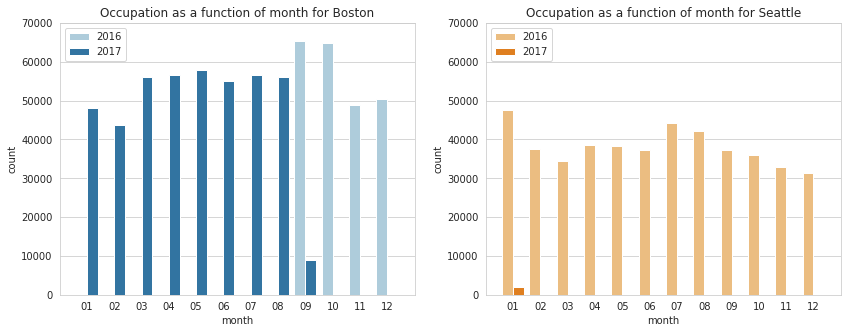

In [1012]:
boston_ = boston_calendar[boston_calendar['price'].isnull()].groupby(['year','month']).size().reset_index()
boston_.rename(columns={0:'count'}, inplace=True)
seattle_ = seattle_calendar[seattle_calendar['price'].isnull()].groupby(['year','month']).size().reset_index()
seattle_.rename(columns={0:'count'}, inplace=True)

sns.set_style("whitegrid")
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
sns.barplot(x='month', y='count', hue='year', data=boston_, ax=ax1, palette=[boston1,boston2]);
ax1.legend(loc='upper left');
ax1.set_title('Occupation as a function of month for Boston')
ax1.set_xlim((-1,12));
ax1.set_ylim((0,70000));
sns.barplot(x='month', y='count', hue='year', data=seattle_, ax=ax2, palette=[seattle1,seattle2]);
ax2.legend(loc='upper left');
ax2.set_title('Occupation as a function of month for Seattle')
ax2.set_xlim((-1,12));
ax2.set_ylim((0,70000));

For Boston, the occupation is quite steady during spring and summer and lower during winter. However, the data doesn't comprise a whole year so we cannot be quite sure about this trend. For Seattle, January is very popular, probably due to winter birds escaping from Canada (like myself). We also see some high demand during the peak of summer. However, as happened with Boston, the data does not show mulitple years so we cannot draw any definite conclusions.

That was too easy. Let's try something fancier. Another way of looking into occupation is to check how many days each unit has been occupied. That's actually not that hard: we simply need to count for how long each unit has been not available throughout the whole dataframe.

In [938]:
boston_calendar['occupied'] = boston_calendar['available'].apply(lambda x: 1 if x=='f' else 0)
seattle_calendar['occupied'] = seattle_calendar['available'].apply(lambda x: 1 if x=='f' else 0)

In [995]:
boston_rent = boston_calendar.groupby('listing_id').agg({'occupied':'sum'}).reset_index()
seattle_rent = seattle_calendar.groupby('listing_id').agg({'occupied':'sum'}).reset_index()

In [1005]:
boston_rent.head()

,listing_id,occupied
0,3353,116
1,5506,21
2,6695,41
3,6976,46
4,8792,117


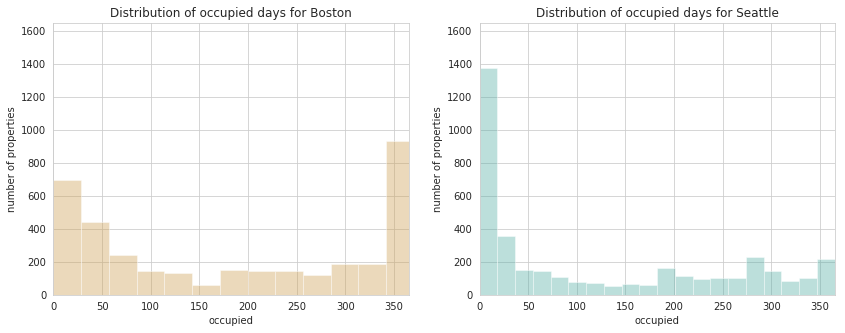

In [1037]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
sns.distplot(boston_rent['occupied'], ax=ax1, kde=False, color=boston2, bins=20);
#ax1.legend(loc='upper left');
ax1.set_title('Distribution of occupied days for Boston')
ax1.set_xlim((0,365));
ax1.set_ylim((0,1650));
ax1.set_ylabel('number of properties')
sns.distplot(seattle_rent['occupied'], ax=ax2, kde=False, color=seattle2, bins=20);
ax2.set_title('Distribution of occupied days for Seattle')
ax2.set_ylim((0,1650));
ax2.set_xlim((0,365))
ax2.set_ylabel('number of properties');

The property occupation for Boston has a peak about 350 days. Are these properties rented out to students? 

Let's create a dataframe containing just the units that were rented out for more than 350 days.

In [998]:
boston_350 = boston_rent[boston_rent['occupied']>350].copy()

In [999]:
boston_350.shape

(856, 2)

In [1000]:
boston_350 = boston_350.merge(boston_listings, how='inner', left_on='listing_id', right_on = 'id')

In [1001]:
boston_350.shape

(856, 97)

In [1002]:
boston_350.groupby('neighbourhood_cleansed').size().sort_values(ascending=False).reset_index()[:10]

,neighbourhood_cleansed,0
0,Allston,108
1,South End,80
2,Jamaica Plain,79
3,Fenway,69
4,Back Bay,66
5,Brighton,58
6,Beacon Hill,55
7,North End,49
8,Mission Hill,47
9,Downtown,45


That's interesting. Allston is quite close to Harvard and more affordable than Cambridge. That's not conclusive, but provides some evidence for my guess that these year-round rented units are occupied by students.

On the other hand, the property occupation for Seattle is what I would imagine as typical: most of the properties were rented for just about a month over an year. Contrasting with Boston, just a few properties were in high demand throughout the year.

Are these long-term rents a measure of success. Of course, the unit is occupied but that might be by just one tenant throughout months. It would be interesting to measure how many times the listing was converted into a new tenant. For that we create a new column containing the average times the unit was rented. We calculate it by simply dividing the days the unit was occupied by the average time it was available (maximum_nights + minimum_nights) / 2.

In [1003]:
def n_rents(df_rent, df_listings):
    df_rent = df_rent.merge(df_listings, how='inner', left_on='listing_id', right_on='id', suffixes=(False,False))
    df_rent['avg_nights'] = (df_listings['maximum_nights'] + df_listings['minimum_nights']) / 2.0
    df_rent['n_rent'] = df_rent['occupied'] / df_rent['avg_nights']
    
    return df_rent

In [1033]:
boston_merge = n_rents(boston_rent, boston_listings)
seattle_merge = n_rents(seattle_rent, seattle_listings)

In [1034]:
boston_merge.shape, boston_listings.shape, boston_merge.isnull().values.any()

((3585, 99), (3585, 95), True)

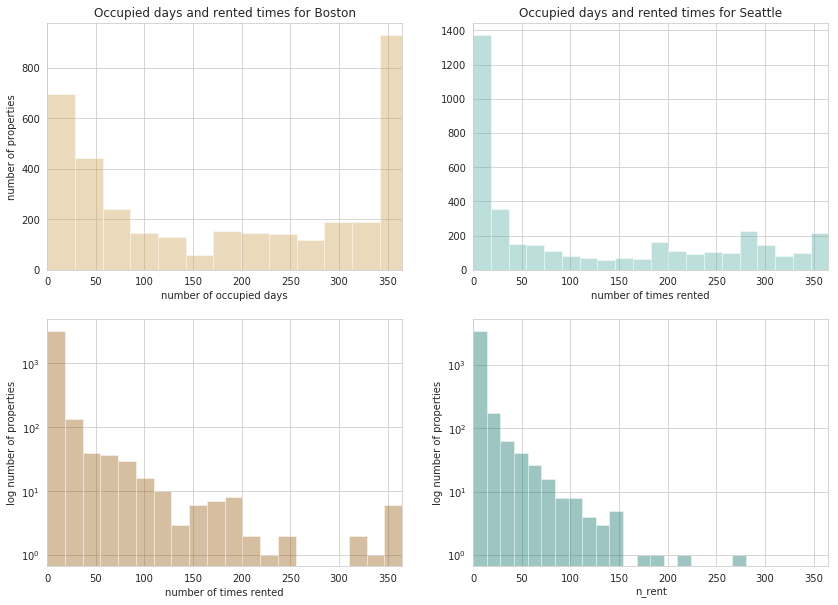

In [1039]:
fig, axes = plt.subplots(2,2, figsize=(14,10))
sns.distplot(boston_rent['occupied'], ax=axes[0][0], kde=False, color=boston2, bins=20);
sns.distplot(boston_merge['n_rent'], ax=axes[1][0], kde=False, color=boston1, bins=20)
#ax1.legend(loc='upper left');
axes[0][0].set_title('Occupied days and rented times for Boston')
axes[0][0].set_xlim((0,365));
axes[0][0].set_xlabel('number of occupied days')
axes[0][0].set_ylabel('number of properties')
axes[1][0].set_xlim((0,365));
axes[1][0].set_yscale('log');
axes[1][0].set_xlabel('number of times rented')
axes[1][0].set_ylabel('log number of properties')
#ax1.set_ylim((0,1650));
sns.distplot(seattle_rent['occupied'], ax=axes[0][1], kde=False, color=seattle2, bins=20);
sns.distplot(seattle_merge['n_rent'], ax=axes[1][1], kde=False, color=seattle1, bins=20);
axes[0][1].set_title('Occupied days and rented times for Seattle')
axes[0][1].set_xlim((0,365));
axes[0][1].set_xlabel('number of occupied days')
axes[1][1].set_ylabel('number of properties')
axes[1][1].set_xlim((0,365));
axes[1][1].set_yscale('log');
axes[0][1].set_xlabel('number of times rented')
axes[1][1].set_ylabel('log number of properties');


That's very good. Measuring with n_rent instead of occupation eliminated most of the long-term renting effect. It gives us a more reliable parameter for how many times a unit catches the attention of a new user. That's important if we want to measure how effective our listing is and how well our property stacks with others in the same category.

## 2. Can we determine what are the main predictors for property price?

This one might be a common question for property owners: What are most important property features that I need to take care of if I want to be successful attracting customers?

I tried to solve this problem by training a supervised learning classifier using four categories of price range as a target. The answer to our question will be in the list of most important features that some types of classifiers return after fitting the model. 

Starting with the merged dataframes that we created above, we narrow down the columns that I guessed might have the highest impact in solving this question.

In [1217]:
# I arbitrarily chose these columns 
list_columns = ['id',
                'host_since',
                'host_response_rate',
                'host_acceptance_rate',
                'host_is_superhost',
                'host_listings_count',
                'neighbourhood_cleansed',
                'property_type',
                'room_type',
                'accommodates',
                'bathrooms',
                'bedrooms',
                'beds',
                'bed_type',
                'amenities',
                'price',
                'minimum_nights',
                'maximum_nights',
                'n_rent',
                'occupied',
                'number_of_reviews',
                'review_scores_rating',
                'review_scores_accuracy',
                'review_scores_cleanliness',
                'review_scores_checkin',
                'review_scores_communication',
                'review_scores_location',
                'review_scores_value',
                'instant_bookable',
                'cancellation_policy',
                'require_guest_profile_picture',
                'require_guest_phone_verification' ]

Some of the columns are obvious but, for example, the column require_guest_profile_picture is not a clear choice. I chose it because if I am a privacy-oriented guest, I would rather not have my picture available on Airbnb (maybe not, that's just a guess. Maybe I would not even use Airbnb).

Let's now define a pipeline to clean the data before processing by a supervised learning method.

In [1218]:
def price_pipeline(df):
    #df.dropna(axis=1, inplace=True) # very few null values for the selected columns
    df.dropna(subset=['host_since'], inplace=True)
    df['host_since'] = df['host_since'].str.split(pat='-', expand=True)[0]
    base_year = pd.to_numeric(df['host_since'].unique().min())
    df['host_since'] = df['host_since'].apply(lambda x: pd.to_numeric(x) - base_year)
    
    df['host_response_rate'].fillna('0%', inplace=True)
    df['host_response_rate'] = df['host_response_rate'].str.replace(r'%', r'.0').astype('float') / 100.0
    df['host_acceptance_rate'].fillna('0%', inplace=True)
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace(r'%', r'.0').astype('float') / 100.0
    
    df['host_is_superhost'] = df['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)    
    df['amenities'] = df['amenities'].str.strip('{,}').str.split(pat=',', expand=True).isnull().sum(axis=1)    
    
    df.dropna(subset=['price'], inplace=True)
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    
    df['instant_bookable'] = df['instant_bookable'].apply(lambda x: 0 if x=='f' else 1)
    df['require_guest_profile_picture'] = df['require_guest_profile_picture'].apply(lambda x: 0 if x=='f' else 1)
    df['require_guest_phone_verification'] = df['require_guest_phone_verification'].apply(lambda x: 0 if x=='f' else 1)

    # imputing missing values
    
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    df['bathrooms'] = imp_median.fit_transform(df[['bathrooms']])
    df['bedrooms'] = imp_median.fit_transform(df[['bedrooms']])
    df['beds'] = imp_median.fit_transform(df[['beds']])
    
    imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df['property_type'] = imp_mf.fit_transform(df[['property_type']])
    
    # review columns section
    review_re = re.compile('^review')
    list_review = list(filter(review_re.match, df.columns.values.tolist()))
    
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    df[list_review] = imp_mean.fit_transform(df[list_review])
    
    # dummies section
    list_dummies = df.select_dtypes(include='object').columns.values.tolist()
    df_dummies = pd.get_dummies(df[list_dummies], drop_first=True)
    df2 = pd.merge(df, df_dummies, left_index=True, right_index=True).drop(list_dummies, axis=1)
    
    # separate id column
    df2_id = df2['id']
    df2.drop('id', axis=1, inplace=True)
    
    # scaler section
    list_scale = df.select_dtypes(include=['float64','int64']).columns.values.tolist()
    list_scale.remove('id')
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    df2[list_scale] = scaler.fit_transform(df2[list_scale])
    
    
    return df2_id, df2

This pipeline returns two dataframes: one with just the ids in case we want to use them later and the other with all selected columns properly cleaned from null values, with categorical variables converted to dummies and with numeric variables scaled. 

In [1219]:
boston_id, boston_df = price_pipeline(boston_merge[list_columns].copy())
seattle_id, seattle_df = price_pipeline(seattle_merge[list_columns].copy())

/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


The next step is to train a regressor with these dataframes. However, after much work, I could not get any regressor to give me any decent result. 

In [1220]:
boston_df.head()

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,n_rent,occupied,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30
0,0.000,0.9,0.78,0.0,0.008011,0.000000,0.166667,0.2,0.0625,0.666667,0.007519,0.020067,3.640000e-06,0.000564,0.203509,0.084158,0.8750,0.875,0.750,0.875,0.833333,0.875,0.875,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
1,0.125,1.0,0.90,0.0,0.009346,0.066667,0.166667,0.2,0.0625,0.766667,0.033835,0.006689,7.290000e-06,0.006769,0.036842,0.089109,0.8875,0.875,1.000,1.000,1.000000,0.875,1.000,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,0.125,1.0,0.90,0.0,0.009346,0.200000,0.166667,0.2,0.1250,0.433333,0.046366,0.006689,7.290000e-06,0.004680,0.071930,0.116337,0.9375,0.875,1.000,1.000,1.000000,0.750,0.875,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0.125,1.0,0.88,1.0,0.001335,0.066667,0.166667,0.2,0.0625,0.433333,0.013784,0.006689,4.400000e-07,0.000224,0.080702,0.101485,0.9750,1.000,0.875,1.000,1.000000,0.875,1.000,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
4,0.125,1.0,0.93,0.0,0.016021,0.133333,0.166667,0.2,0.0625,0.733333,0.036090,0.096990,3.640000e-06,0.019427,0.205263,0.044554,0.8875,1.000,0.875,1.000,0.833333,1.000,1.000,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [1221]:
bdf = boston_df.copy()
target='price'
y = bdf[target]
X = bdf.drop([target],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
ab_reg = AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=1.0)
ab_reg.fit(X_train, y_train)
y_preds = ab_reg.predict(X_test)
r2_score(y_test,y_preds)

0.061104666346825764

My guess is that the datasets are too sparse and too small for any regressor to perform well. Moreover, if we inspect pairs of variables using scatter plots, we can see that there is no clear trend in the data.

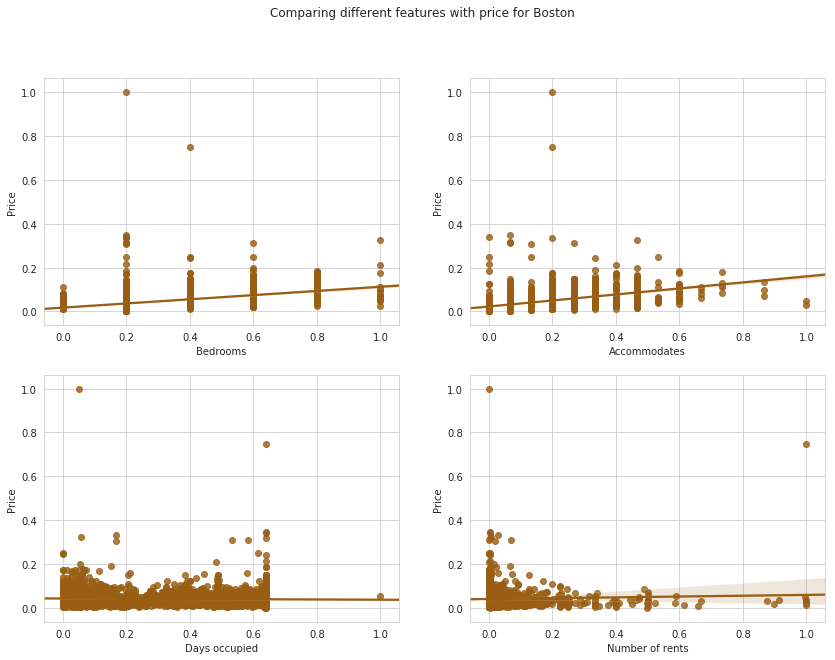

In [1227]:
select_df = boston_df[['bedrooms','occupied','accommodates','price','n_rent']].copy()
fig, axes = plt.subplots(2,2, figsize=(14,10))
sns.regplot(x='bedrooms', y='price', data=select_df, ax=axes[0][0], color=boston1);
sns.regplot(x='occupied', y='price', data=select_df, ax=axes[1][0], color=boston1)
sns.regplot(x='accommodates', y='price', data=select_df, ax=axes[0][1], color=boston1);
sns.regplot(x='n_rent', y='price', data=select_df, ax=axes[1][1], color=boston1)
#ax1.legend(loc='upper left');
plt.suptitle('Comparing different features with price for Boston')
axes[0][0].set_xlabel('Bedrooms')
axes[0][0].set_ylabel('Price')
axes[1][0].set_xlabel('Days occupied')
axes[1][0].set_ylabel('Price')
axes[0][1].set_xlabel('Accommodates')
axes[0][1].set_ylabel('Price')
axes[1][1].set_xlabel('Number of rents')
axes[1][1].set_ylabel('Price');

One solution for this issue is to turn a regression problem into a classification problem. We define four price categories based on the quartiles of the price distribution and make predictions about these classes.

Using Ada Boost as the classifier, we run 5-fold cross-validation cycles, getting an acceptable result.

In [1243]:
bdf = boston_df.copy()
target='price'
qt = bdf[target].quantile([.25,.50,.75]).values.tolist()
bdf['score'] = bdf[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bdf.drop(target, axis=1, inplace=True)
y = bdf['score']
X = bdf.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
skf = StratifiedKFold(n_splits=5, random_state=34)
y_true = []
y_preds = []
for train_idx, test_idx in skf.split(X_train, y_train):
    X_train_kf, y_train_kf = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
    X_test_kf, y_test_kf = X_train.iloc[test_idx, :], y_train.iloc[test_idx]
    ab_clf.fit(X_train_kf, y_train_kf)
    y_preds.extend(ab_clf.predict(X_test_kf))
    y_true.extend(y_test_kf)
    
print(accuracy_score(y_true, y_preds))

0.5618492294877134


Next, we can use some tricks to improve this result. We first run GridSearchCV to optimize the hyperparameters.

In [1244]:
parameters = {'learning_rate': np.arange(0.1,1.1,0.1), 'n_estimators':[100, 150, 200, 250, 300, 350, 400, 500, 1000]}
grid_clf = GridSearchCV(ab_clf, parameters, cv=5)
grid_clf.fit(X_train, y_train)
print(grid_clf.best_score_)
best_clf = grid_clf.best_estimator_

0.5672636401499376


That didn't improve a lot.

Next, we try to optimize the dataframe itself by selecting the columns to be considered. One way to do this is by adding all the elements of each column and only picking the column if the sum is less than some cutoff.

In [1231]:
cutoffs=[2500, 2000, 1500, 1000, 500, 100, 50, 30, 25, 0]
for c in cutoffs:
    X_red = X_train.iloc[:, np.where((X.sum()>c)==True)[0]]
    skf = StratifiedKFold(n_splits=5, random_state=34)
    y_true_c = []
    y_preds_c = []
    for train_idx, test_idx in skf.split(X_red, y_train):
        X_train_kf, y_train_kf = X_red.iloc[train_idx, :], y_train.iloc[train_idx]
        X_test_kf, y_test_kf = X_red.iloc[test_idx, :], y_train.iloc[test_idx]
        best_clf.fit(X_train_kf, y_train_kf)
        y_preds_c.extend(best_clf.predict(X_test_kf))
        y_true_c.extend(y_test_kf)
    print('cuttoff: {}, accuracy: {}'.format(c, accuracy_score(y_true_c, y_preds_c)))

cuttoff: 2500, accuracy: 0.3669304456476468
cuttoff: 2000, accuracy: 0.3669304456476468
cuttoff: 1500, accuracy: 0.40816326530612246
cuttoff: 1000, accuracy: 0.4839650145772595
cuttoff: 500, accuracy: 0.5531028738025823
cuttoff: 100, accuracy: 0.5601832569762599
cuttoff: 50, accuracy: 0.5618492294877134
cuttoff: 30, accuracy: 0.5622657226155768
cuttoff: 25, accuracy: 0.5664306538942108
cuttoff: 0, accuracy: 0.5668471470220742


Using all columns (the smaller the cutoff the more columns are used) led to the best result. We don't drop any column.

Another interesting way of optimizing the dataframe is by using Recursive Feature Elimination. Despite the ugly name, this technique is not that complicated. We define the number of features we want and RFE will eliminate the least important columns until we get that number.

In [1234]:
rfe_n = []
rfe_acc = []
for i in range(2,X.shape[1]):
    rfe_ab = RFE(best_clf, n_features_to_select=i)
    rfe_ab = rfe_ab.fit(X, y)
    X_red = X_train.iloc[:,rfe_ab.support_]
    rfe_n.append(i)
    
    skf = StratifiedKFold(n_splits=5, random_state=34)
    y_true_rfe = []
    y_preds_rfe = []
    for train_idx, test_idx in skf.split(X_red, y_train):
        X_train_kf, y_train_kf = X_red.iloc[train_idx, :], y_train.iloc[train_idx]
        X_test_kf, y_test_kf = X_red.iloc[test_idx, :], y_train.iloc[test_idx]
        best_clf.fit(X_train_kf, y_train_kf)
        y_preds_rfe.extend(best_clf.predict(X_test_kf))
        y_true_rfe.extend(y_test_kf)
    rfe_acc.append(accuracy_score(y_true_rfe, y_preds_rfe))

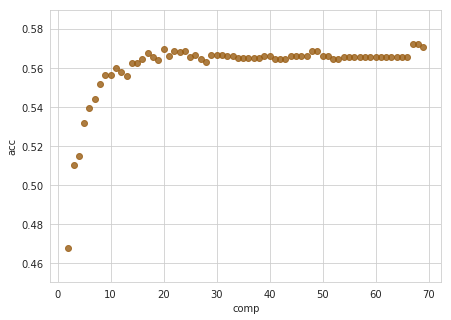

In [1241]:
df_rfe = pd.DataFrame({'comp':rfe_n, 'acc':rfe_acc})
fig, ax1 = plt.subplots(1, figsize=(7,5))
sns.regplot(x='comp', y='acc', ax=ax1, data=df_rfe, color=boston1, fit_reg=False);
plt.title('Results for Recursive Feature Elimination')

In [1245]:
accuracy_score(y_test, best_clf.predict(X_test))

0.5641891891891891

In [1246]:
best_clf.fit(X, y)
features = pd.Series(data=best_clf.feature_importances_, index = X.columns)
features.sort_values(ascending=False, inplace=True)
print(features[:10])

room_type_Private room                0.105
accommodates                          0.090
bedrooms                              0.070
neighbourhood_cleansed_Downtown       0.060
room_type_Shared room                 0.060
neighbourhood_cleansed_Back Bay       0.055
neighbourhood_cleansed_South End      0.050
neighbourhood_cleansed_Beacon Hill    0.050
amenities                             0.040
review_scores_location                0.040
dtype: float64


Now we do the same for Seattle (except for the optimization of the dataset):

In [ ]:
sdf = seattle_df.copy()
target='price'
qt = sdf[target].quantile([.25,.50,.75]).values.tolist()
sdf['score'] = sdf[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
sdf.drop(target, axis=1, inplace=True)
y = sdf['score']
X = sdf.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
skf = StratifiedKFold(n_splits=5, random_state=34)
y_true = []
y_preds = []
for train_idx, test_idx in skf.split(X_train, y_train):
    X_train_kf, y_train_kf = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
    X_test_kf, y_test_kf = X_train.iloc[test_idx, :], y_train.iloc[test_idx]
    ab_clf.fit(X_train_kf, y_train_kf)
    y_preds.extend(ab_clf.predict(X_test_kf))
    y_true.extend(y_test_kf)
    
print(f'accuracy score: {accuracy_score(y_true, y_preds)}')

parameters = {'learning_rate': np.arange(0.1,1.1,0.1), 'n_estimators':[100, 150, 200, 250, 300, 350, 400, 500, 1000]}
grid_clf = GridSearchCV(ab_clf, parameters, cv=5)
grid_clf.fit(X_train, y_train)
print(f'Grid best score: {grid_clf.best_score_}')
best_clf = grid_clf.best_estimator_
accuracy_score(y_test, best_clf.predict(X_test))
best_clf.fit(X, y)
features = pd.Series(data=best_clf.feature_importances_, index = X.columns)
features.sort_values(ascending=False, inplace=True)
print(features[:10])

accuracy score: 0.5539906103286385


In question 2 we asked if we can determine what are the main predictors for property price. The answer is yes, given that we create different classes for the price value. 

We found that for Boston the most important features determining price are:

1. Room is a private room
2. Number of people that can be accommodated in the property
3. Number of bedrooms
4. If the property is in Downtown
5. If the room is a shared room.

For Seattle the result is mostly the same. The important features determining price are:

1. Room is a private room
2. Number of people that can be accomodated in the property
3. Numbear 


## 3. What are the characteristics of the most sought after properties?

We would like to know what are the characteristics of a property that is in high demand. Following the same approach we used for the previous question, we define a four-star classification based this time in the feature n_rent which is  the number of times a unit was rented during the entire time period of the dataset.

The idea here is to use PCA to reduce dimensionality of the dataset and to aggregate original features into new variables, which are more meaningful for this problem. Then, using k-means clustering, we find how these features are aggregated in different classes. Last, we find to which classes most of the 4-star properties belong. Fear not! This is not as complicated as it sounds.

In [1235]:
bdf_pca = boston_df.copy()
sdf_pca = seattle_df.copy()

target='n_rent'
qt = bdf_pca[target].quantile([.25,.50,.75]).values.tolist()
boston_target = pd.Series(bdf_pca[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1))) )

qt = sdf_pca[target].quantile([.25,.50,.75]).values.tolist()
seattle_target = pd.Series(sdf_pca[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1))) )

In [507]:
def pca(df, n_components):
    '''
    Generates PCA model
    
    INPUT: df - scaled dataframe
           n_components - number of components for the model
           
    OUTPUT: pca_model - PCA object
            var_pca - dataframe with components and explained variances
            X_pca - numpy array with transformed data
    '''
    pca_model = PCA(n_components)
    X_pca = pca_model.fit_transform(df)
    components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df.keys())
    ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)
    dimensions = ['Dim {}'.format(i) for i in range(len(pca_model.components_))]
    components.index = dimensions
    variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])
    variance_ratios.index = dimensions
    var_pca = pd.concat([variance_ratios, components], axis=1)
    
    return pca_model, var_pca, X_pca

In [508]:
pca_model, var_pca, X_pca = pca(bldf2, 10)

In [537]:
var_pca.head()

,Explained_Variance,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,price,cleaning_fee,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,n_years,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa
Dim 0,0.4770,0.0186,-0.0033,0.0102,0.0140,0.0073,0.0022,0.0073,0.0026,0.0024,0.0015,0.0199,0.0005,0.0002,0.0125,-0.0170,0.0137,0.0607,-0.9934,0.0350,-0.0308,-0.0043,-0.0010,-0.0007,-0.0015,-0.0001,0.0032,-0.0557,0.0067,0.0139,0.0351,-0.0095,0.0091,-0.0004,0.0017,-0.0104,0.0015,-0.0015,0.0022,0.0055,-0.0023,-0.0090,-0.0027,0.0111,0.0002,-0.0006,-0.0019,-0.0017,0.0022,0.0008,0.0057,-0.0038,-0.0029,0.0067,0.0011,-0.0012,0.0073,0.0018,0.0023,-0.0002,-0.0070,-0.0002,-0.0002,-0.0002,-0.0011,0.0006,0.0016,-0.0047,-0.0001
Dim 1,0.0933,-0.0406,0.0134,0.0334,-0.1009,-0.0736,-0.0041,-0.0455,-0.0254,0.0443,-0.0198,-0.1150,-0.0013,-0.0003,0.0136,0.0220,0.0100,-0.0139,-0.0635,-0.5784,0.5702,0.0082,0.0123,0.0019,0.0119,0.0042,-0.0304,0.2185,0.0945,-0.2982,-0.0148,0.0394,-0.0739,-0.0032,-0.0373,0.0263,0.0047,-0.0203,0.0784,-0.0323,0.0140,-0.0414,0.0116,0.0637,0.0007,0.0007,0.0094,0.0143,-0.0250,0.0167,0.0219,0.0076,-0.0190,-0.0555,-0.0141,0.0126,-0.2697,0.0166,-0.0012,-0.0001,0.0099,0.0010,0.0009,-0.0003,0.2227,-0.0001,0.0043,0.0139,0.0021
Dim 2,0.0590,0.2885,0.2950,0.0982,-0.0007,0.0132,0.0209,0.0147,0.0084,-0.0426,-0.0052,0.0488,0.0009,0.0004,0.0299,0.1465,0.0122,-0.0416,0.0208,-0.1280,0.1402,-0.0122,0.0010,-0.0004,-0.0008,-0.0051,0.0052,-0.4272,-0.1524,0.6174,-0.0379,0.0208,-0.0280,0.0028,0.0037,0.0023,-0.0023,0.0004,0.0310,-0.0225,0.0059,-0.0677,0.0051,0.0112,-0.0009,-0.0013,0.0087,-0.0086,-0.0076,0.0112,0.0139,0.0148,-0.0066,0.0061,-0.0009,0.0085,-0.3193,0.0143,0.0045,-0.0004,0.0482,-0.0001,-0.0002,0.0006,0.2291,0.0023,0.0063,0.0169,-0.0023
Dim 3,0.0461,0.2506,0.2407,0.0924,-0.0175,0.0140,-0.0027,0.0107,0.0083,-0.0584,0.0009,0.0100,-0.0017,-0.0002,0.0275,0.0109,0.0157,0.0623,0.0377,0.0825,-0.0714,-0.0111,0.0125,0.0002,0.0011,0.0001,-0.0139,-0.4057,0.7486,-0.3369,-0.0060,-0.0577,-0.0095,0.0038,-0.0133,-0.0104,-0.0042,-0.0012,0.0368,0.0039,0.0104,0.0015,-0.0021,0.0492,0.0029,0.0016,-0.0010,0.0007,-0.0048,0.0021,-0.0010,0.0058,0.0046,-0.0122,-0.0018,-0.0039,-0.0271,-0.0022,-0.0022,0.0006,0.0170,-0.0007,0.0024,0.0000,0.0109,0.0028,-0.0056,0.0065,-0.0023
Dim 4,0.0371,-0.0720,-0.0513,0.0260,-0.0355,0.0753,0.0377,0.0846,0.0393,-0.0381,0.0138,0.0293,-0.0009,-0.0002,0.0008,0.0549,-0.0073,-0.0140,-0.0011,0.3331,-0.3238,-0.0093,-0.0264,-

In [538]:
def pca_analysis(var_pca, component):
    '''
    Generate a dataframe with the attributes listed by weight for
    a given component.
    
    INPUT: var_pca - dataframe with the PCA output
           component - number of the component
           
    OUTPUT: dataframe with attributes and weights
    '''
    
    df = pd.DataFrame(var_pca.iloc[component,:].sort_values(axis=0, ascending=False))
    df['attribute {}'.format(component)] = df.index
    df.set_index(np.arange(var_pca.shape[1]), inplace=True)

    return df

In [539]:
list_df = []
#var_pca.drop('Explained_Variance', axis=1, inplace=True)
for i in range(1:10):
    list_df.append(pca_analysis(var_pca, i))
var_comp = pd.concat([x for x in list_df],axis=1)

In [540]:
var_comp.head()

,Dim 0,attribute 0,Dim 1,attribute 1,Dim 2,attribute 2,Dim 3,attribute 3,Dim 4,attribute 4,Dim 5,attribute 5,Dim 6,attribute 6,Dim 7,attribute 7,Dim 8,attribute 8,Dim 9,attribute 9
0,0.0607,require_guest_phone_verification,0.5702,room_type_Private room,0.6174,cancellation_policy_strict,0.7486,cancellation_policy_moderate,0.4278,property_type_House,0.2221,cancellation_policy_moderate,0.8671,instant_bookable,0.6243,host_is_superhost,0.5666,neighbourhood_cleansed_South End,0.4759,property_type_Condominium
1,0.0351,cancellation_policy_super_strict_30,0.2227,property_type_House,0.2950,host_acceptance_rate,0.2506,host_response_rate,0.3331,room_type_Entire home/apt,0.2008,cancellation_policy_strict,0.1278,cancellation_policy_moderate,0.3881,neighbourhood_cleansed_Jamaica Plain,0.4275,property_type_Condominium,0.4552,neighbourhood_cleansed_Jamaica Plain
2,0.0350,room_type_Entire home/apt,0.2185,cancellation_policy_flexible,0.2885,host_response_rate,0.2407,host_acceptance_rate,0.2332,cancellation_policy_flexible,0.1027,property_type_House,0.1277,neighbourhood_cleansed_Allston,0.2866,neighbourhood_cleansed_South End,0.0876,neighbourhood_cleansed_Dorchester,0.2478,neighbourhood_cleansed_Back Bay
3,0.0199,cleaning_fee,0.0945,cancellation_policy_moderate,0.2291,property_type_House,0.0924,host_is_superhost,0.1703,property_type_Condominium,0.0754,room_type_Private room,0.0530,property_type_Condominium,0.0740,cancellation_policy_strict,0.0851,host_acceptance_rate,0.1682,neighbourhood_cleansed_Fenway
4,0.0186,host_response_rate,0.0784,neighbourhood_cleansed_Dorchester,0.1465,instant_bookable,0.0825,room_type_Entire home/apt,0.0846,bedrooms,0.0533,host_listings_count,0.0446,neighbourhood_cleansed_Brighton,0.0623,property_type_Apartment,0.0809,neighbourhood_cleansed_South Boston,0.1395,host_listings_count


In [481]:
n_clusters = 10
k_model_final = KMeans(n_clusters = n_clusters, random_state=34).fit(X_pca)
k_score_final = k_model_final.score(X_pca)
k_score_final

-5563.276564928061

In [482]:
# generate dataframe with partial populations in each cluster
k_pop = pd.DataFrame(np.unique(k_model_final.labels_), columns=['cluster'])
k_pop['population'] = np.bincount(k_model_final.labels_) / k_model_final.labels_.shape[0]

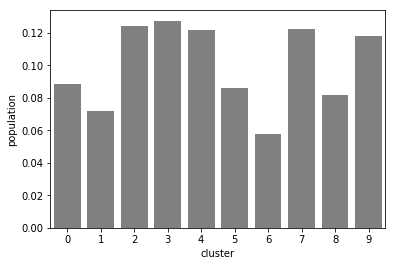

In [483]:
sns.barplot(x = 'cluster', y = 'population', data=k_pop, color='gray')

In [484]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = bldf2.index.values
cluster_map['score']=score_target
cluster_map['cluster'] = k_model_final.labels_

In [485]:
cluster_map[cluster_map['score']==4]['cluster'].value_counts()

2    197
7    154
0    146
4    141
8    100
3     96
5     80
1     73
6     59
9     54
Name: cluster, dtype: int64

## 4. What are the most popular neighbourhoods? Can we understand why they are popular?

In [356]:
# 40% of neighborhood overviews missing
boston_listings['neighborhood_overview'].isnull().mean()

0.3947001394700139

We take the rest and convert to a new dataframe

In [398]:
bl_no = boston_listings.loc[boston_listings['neighborhood_overview'].notnull(), 
                            ['host_neighbourhood','neighborhood_overview']]
bl_no.head()

,host_neighbourhood,neighborhood_overview
0,Roslindale,"Roslindale is quiet, convenient and friendly. ..."
1,Roslindale,"The room is in Roslindale, a diverse and prima..."
2,Roslindale,The LOCATION: Roslindale is a safe and diverse...
3,NaN,Roslindale is a lovely little neighborhood loc...
4,Roslindale,"I love the proximity to downtown, the neighbor..."


In [399]:
bl_no.shape

(2170, 2)

In [401]:
bl_no_grouped = bl_no.groupby('host_neighbourhood').agg({'neighborhood_overview':'sum'}).reset_index()
bl_no_grouped.head()

,host_neighbourhood,neighborhood_overview
0,Allston-Brighton,The Back Bay neighborhood runs along the Charl...
1,Back Bay,"Living at The Longwood Apartments, residents w..."
2,Beacon Hill,Great location! Walk to the Longwood Medical A...
3,Belváros,Conveniently located across from premier shopp...
4,Benton Park,"Once called ""The Eden of America"" by a visitor..."


In [402]:
bl_no_grouped.shape

(46, 2)

In [403]:
my_stop_words=['boston']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)

In [414]:
list_msg=[]
for i in range(bl_no_grouped.shape[0]):
    count_vect = CountVectorizer(stop_words=stop_words, ngram_range=(2,2))
    X_train = count_vect.fit_transform([bl_no_grouped.loc[i,'neighborhood_overview']])
    lda = LatentDirichletAllocation(n_components=1,random_state=34)
    lda.fit(X_train) 
    feature_names = count_vect.get_feature_names()
    for idx, topic in enumerate(lda.components_):
        message = " ".join([feature_names[i] for i in topic.argsort()[:-8 :-1]])
    list_msg.extend([message])

In [415]:
bl_no_grouped['message']=list_msg

In [416]:
list_msg

['harvard square walking distance restaurants bars close harvard easy access grocery store minute walk',
 'newbury street beacon hill charles river walking distance prudential center minute walk south end',
 'beacon hill public transportation newbury street steps public financial district south end mall newbury',
 'water shuttle silver line shopping dining premier shopping nightlife easy major highways located premier',
 'jamaica pond jamaica plain forrest hills dining spots doyle pub earth jamaica eden america',
 'walkable attractions walk food attractions mgh center commons charles river charles street commons gardens',
 'walking access conveniences borough folks looking favorite neighborhoods excellent safe enjoying conveniences easy walking',
 'right street lounges surrounding leisurely traveling plenty restaurants bike rentals street chinatown hr diner',
 'waterfront park park home home bruins home red garden home fenway park faneuil hall',
 'bunker hill navy yard hill monument fr

In [486]:
bl_no_grouped[['host_neighbourhood','message']]

,host_neighbourhood,message
0,Allston-Brighton,harvard square walking distance restaurants ba...
1,Back Bay,newbury street beacon hill charles river walki...
2,Beacon Hill,beacon hill public transportation newbury stre...
3,Belváros,water shuttle silver line shopping dining prem...
4,Benton Park,jamaica pond jamaica plain forrest hills dinin...
5,Bernal Heights,walkable attractions walk food attractions mgh...
6,Brookline,walking access conveniences borough folks look...
7,Cambridge,right street lounges surrounding leisurely tra...
8,Central Business District,waterfront park park home home bruins home red...
9,Charlestown,bunker hill navy yard hill monument freedom tr...


In [247]:
# adaboost classifier with target as occupied
bldf2 = bldf.drop(['id','n_rent'], axis=1)
qt = bldf2['occupied'].quantile([.25,.50,.75]).values.tolist()
bldf2['score'] = bldf2['occupied'].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bldf2.drop('occupied', axis=1, inplace=True)
#bldf2.score.value_counts()
y = bldf2['score']
X = bldf2.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
#ab_clf = AdaBoostClassifier(learning_rate=0.2, random_state=34, n_estimators = 200)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
y_preds = ab_clf.predict(X_test)
print(accuracy_score(y_test, y_preds))
print(confusion_matrix(y_test,y_preds))
features = pd.Series(data=ab_clf.feature_importances_, index = X.columns).sort_values(ascending=False)
print(features[:10])

0.47550675675675674
[[115  81  57  53]
 [ 63 124  31  59]
 [ 41  71 122  75]
 [ 18  33  39 202]]
host_listings_count                 0.30
number_of_reviews                   0.18
cleaning_fee                        0.08
host_response_rate                  0.06
host_acceptance_rate                0.06
property_type_House                 0.04
price                               0.04
neighbourhood_cleansed_North End    0.04
maximum_nights                      0.04
room_type_Entire home/apt           0.04
dtype: float64


In [253]:
bldf[['occupied','review_agg','n_rent']].corr()

,occupied,review_agg,n_rent
occupied,1.000000,0.108954,0.267128
review_agg,0.108954,1.000000,0.071865
n_rent,0.267128,0.071865,1.000000


In [249]:
# adaboost classifier with target as review_agg
target='review_agg'
bldf2 = bldf.drop(['id','n_rent'], axis=1)
qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
bldf2['score'] = bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bldf2.drop(target, axis=1, inplace=True)
#bldf2.score.value_counts()
y = bldf2['score']
X = bldf2.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
#ab_clf = AdaBoostClassifier(learning_rate=0.2, random_state=34, n_estimators = 200)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
y_preds = ab_clf.predict(X_test)
print(accuracy_score(y_test, y_preds))
print(confusion_matrix(y_test,y_preds))
features = pd.Series(data=ab_clf.feature_importances_, index = X.columns).sort_values(ascending=False)
print(features[:10])

0.6182432432432432
[[ 77 123  61]
 [ 46 142 118]
 [ 26  78 513]]
number_of_reviews                   0.20
host_is_superhost                   0.16
host_listings_count                 0.16
price                               0.12
amenities                           0.10
accommodates                        0.06
occupied                            0.06
host_response_rate                  0.06
neighbourhood_cleansed_Roxbury      0.02
require_guest_phone_verification    0.02
dtype: float64


In [211]:
X.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,price,cleaning_fee,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,n_years,review_agg,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,n_rent
0,0.9,0.78,0,0.008011,0.000000,0.166667,0.2,0.0625,0.666667,0.007519,0.166667,0.020067,3.640000e-06,0.084158,0,0,0,0,0.840909,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.623656
1,1.0,0.90,0,0.009346,0.066667,0.166667,0.2,0.0625,0.766667,0.033835,0.133333,0.006689,7.290000e-06,0.089109,0,0,0,1,0.954545,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.057299
2,1.0,0.90,0,0.009346,0.200000,0.166667,0.2,0.1250,0.433333,0.046366,0.233333,0.006689,7.290000e-06,0.116337,0,0,0,1,0.909091,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.111869
3,1.0,0.88,1,0.001335,0.066667,0.166667,0.2,0.0625,0.433333,0.013784,0.000000,0.006689,4.400000e-07,0.101485,0,1,0,1,0.954545,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.916667
4,1.0,0.93,0,0.016021,0.133333,0.166667,0.2,0.0625,0.733333,0.036090,0.833333,0.096990,3.640000e-06,0.044554,0,0,0,1,0.954545,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.592405


In [208]:
# adaboost regression with target as n_rent
bldf2 = bldf.copy()
bldf2 = bldf.drop('id', axis=1)
#qt = bldf2['n_rent'].quantile([.25,.50,.75]).values.tolist()
#bldf2['score'] = bldf2['n_rent'].apply(lambda x: 4 if x >= qt[2] else 
#                                                   (3 if x >= qt[1] and x < qt[2] else 
#                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
#bldf2.score.value_counts()
y = bldf2['n_rent']
X = bldf2.drop(['n_rent'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
ab_reg = AdaBoostRegressor(random_state=34)
ab_reg.fit(X_train, y_train)
y_preds = ab_reg.predict(X_test)
r2_score(y_test, y_preds)

-0.1769226026796813

In [267]:
# svm regression with target as n_rent
bldf2 = bldf.copy()
bldf2 = bldf.drop('id', axis=1)
#qt = bldf2['n_rent'].quantile([.25,.50,.75]).values.tolist()
#bldf2['score'] = bldf2['n_rent'].apply(lambda x: 4 if x >= qt[2] else 
#                                                   (3 if x >= qt[1] and x < qt[2] else 
#                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
#bldf2.score.value_counts()
y = bldf2['n_rent']
X = bldf2.drop(['n_rent'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
svr = SVR(kernel='rbf', gamma=2/bldf2.shape[1], C=1.0)
svr.fit(X_train, y_train)
y_preds = svr.predict(X_test)
r2_score(y_test, y_preds)

-0.07902805114255984

In [268]:
# svm regression with target as occupied
bldf2 = bldf.copy()
bldf2 = bldf.drop('id', axis=1)
target='occupied'
#qt = bldf2['n_rent'].quantile([.25,.50,.75]).values.tolist()
#bldf2['score'] = bldf2['n_rent'].apply(lambda x: 4 if x >= qt[2] else 
#                                                   (3 if x >= qt[1] and x < qt[2] else 
#                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
#bldf2.score.value_counts()
y = bldf2[target]
X = bldf2.drop([target],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
svr = SVR(kernel='rbf', gamma=2/bldf2.shape[1], C=1.0)
svr.fit(X_train, y_train)
y_preds = svr.predict(X_test)
r2_score(y_test, y_preds)

0.6070861489383436

In [271]:
selector = RFE(svr, 5, step=1)
selector = selector.fit(X_train, y_train)
selector.support_ 
#selector.ranking_

RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [741]:
br_no = boston_reviews.loc[boston_reviews['comments'].notnull(), 
                            ['date','listing_id','comments']]
br_no_grouped = br_no.groupby('listing_id').agg({'comments':'sum'}).reset_index()

In [742]:
revScore = br_no_grouped.merge(boston_listings[['id','review_scores_rating']], left_on='listing_id', right_on='id')

In [743]:
revScore.dropna(inplace=True)

In [748]:
revScore.drop('id',axis=1, inplace=True)

In [787]:
revScore.reset_index(inplace=True)

In [788]:
revScore.head(20)

,index,listing_id,comments,review_scores_rating
0,0,3353,Very friendly and helpful. Convenient location...,90.0
1,1,5506,Terry's Hotel Alterntv in Boston was a perfect...,91.0
2,2,6695,Terry's apartment is beautifully decorated and...,95.0
3,3,6976,"A Wonderful, pleasant, and charming host. The...",98.0
4,4,8792,"The unit was quiet, convenient, & excellently ...",91.0
5,5,9273,Very patient even when we were having technica...,100.0
6,6,9765,Everything was great. I wish they had advertis...,89.0
7,7,9824,The location for the Back Bay Studio (on Heref...,78.0
8,8,9855,"I stayed in the studio in lston St 1330, BoyFe...",90.0
9,9,9857,"The apartment was very nice and comfortable, a...",87.0


In [781]:
#count_vect = CountVectorizer(stop_words = stop_words, min_df=100, max_df=3000, ngram_range=(1,2), max_features=40000)
count_vect = CountVectorizer(stop_words = stop_words, ngram_range=(1,2), max_features=40000)
#X_counts = count_vect.fit_transform(revScore['comments'])
X_counts = count_vect.fit_transform([revScore.loc[10,'comments']])
count_vect.vocabulary_

KeyError: 10

In [793]:
list_review=[]
for i in range(revScore.shape[0]):
    count_vect = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), max_features=40000)
    X_train = count_vect.fit_transform([revScore.loc[i,'comments']])
    lda = LatentDirichletAllocation(n_components=1,random_state=34)
    lda.fit(X_train) 
    feature_names = count_vect.get_feature_names()
    for idx, topic in enumerate(lda.components_):
        message = " ".join([feature_names[i] for i in topic.argsort()[:-8 :-1]])
    list_review.extend([message])

In [798]:
revScore['message']=list_review

In [803]:
def search_good(list1):
    set1 = set(list1)
    set2 = set(['great','easy','clean','excellent','good','nice'])
    return bool(set1.intersection(set2))

In [804]:
l1 = ['nice','apartment']
search_good(l1)

True

In [813]:
# search for great easy clean excellent good nice
revScore['message'].apply(lambda x: search_good(x.split()))
#column = revScore['message'].apply(lambda x: x.split())[0]

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8       False
9        True
10       True
11       True
12       True
13       True
14      False
15       True
16      False
17      False
18       True
19      False
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
30       True
31       True
32       True
33      False
34       True
35       True
36       True
37       True
38       True
39       True
40       True
41       True
42       True
43       True
44       True
45       True
46       True
47       True
48       True
49      False
50       True
51       True
52       True
53      False
54       True
55      False
56      False
57       True
58      False
59       True
60       True
61       True
62       True
63       True
64       True
65       True
66       True
67       True
68       True
69       True
70      False
71    

In [810]:
search_good(column)

True

In [260]:
# svm regression with target as review_agg
bldf2 = bldf.copy()
bldf2 = bldf.drop('id', axis=1)
target='review_agg'
#qt = bldf2['nnt'].quantile([.25,.50,.75]).values.tolist()
#bldf2['score'] = bldf2['n_rent'].apply(lambda x: 4 if x >= qt[2] else 
#                                                   (3 if x >= qt[1] and x < qt[2] else 
#                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
#bldf2.score.value_counts()
y = bldf2[target]
X = bldf2.drop([target],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
svr = SVR(kernel='rbf', gamma=1/bldf2.shape[1], C=1.0)
svr.fit(X_train, y_train)
y_preds = svr.predict(X_test)
r2_score(y_test, y_preds)

-0.14801518102447386

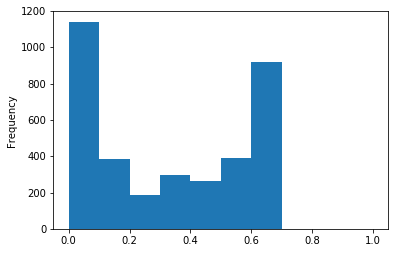

In [131]:
bldf2.occupied.plot.hist()

In [132]:
bldf2['occupied'].quantile([.25,.50,.75])

0.25    0.070175
0.50    0.326316
0.75    0.607018
Name: occupied, dtype: float64

In [124]:
#bldf2['review_agg'].quantile([.25,.5,.75])

In [168]:
#y = bldf2['occupied']
y = bldf2['return']
#X = bldf2.drop(['occupied'],axis=1)
X = bldf2.drop(['return'],axis=1)

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [170]:
reg_lasso = Lasso(alpha=0.1)
reg_lasso.fit(X_train, y_train)
y_preds = reg_lasso.predict(X_test)
r2_score(y_test,y_preds)

-6.0700303552874146e-05

In [171]:
ab_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), random_state=34, n_estimators = 500)
ab_reg.fit(X_train, y_train)
y_preds = ab_reg.predict(X_test)
r2_score(y_test,y_preds)

-2.3045953302755238